In [47]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset


df = load_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
features = [
    "import_capacity",
    # "min_price_published",
    "mid_price_published",
    # "max_price_published",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # 'min_ptu_price_known',
    # "max_ptu_price_known",
    # "settlement_price_bestguess",
    'PTU',
    # 'forecast_wind',
    # 'forecast_solar',
    # 'forecast_demand',
    'time_since_last_two_sided',
    'two_sided_daily_count',
]

splits = get_splits(df, ['PTU', 'import_capacity'], return_dict_pair=False)

train_x = splits['train'][0]
train_y = splits['train'][1]

valid_x = splits['valid'][0]
valid_y = splits['valid'][1]
valid_ids = splits['valid'][2]


test_x = splits['test'][0]
test_y = splits['test'][1]
ids = splits['test'][2]

# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# valid_x = scaler.transform(valid_x)

train_x_tensor = torch.tensor(train_x.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.long)
valid_x_tensor = torch.tensor(valid_x.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y.values, dtype=torch.long)

train_y_mask = ~torch.isnan(train_y_tensor)
valid_y_mask = ~torch.isnan(valid_y_tensor)

# Replace NaN targets with arbitrary values (these won't affect the loss due to masking)
train_y_tensor[~train_y_mask] = 0
valid_y_tensor[~valid_y_mask] = 0

# Create DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor, train_y_mask)
valid_dataset = TensorDataset(valid_x_tensor, valid_y_tensor, valid_y_mask)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [49]:
# class ImprovedSimpleNN(nn.Module):
#     def __init__(self):
#         super(ImprovedSimpleNN, self).__init__()
#         self.fc1 = nn.Linear(train_x.shape[1], 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 2)
#         self.dropout = nn.Dropout(0.5)  # Add dropout layer
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)  # Apply dropout
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)  # Apply dropout
#         x = self.sigmoid(self.fc3(x))
#         return x
    
class ImprovedSimpleNN(nn.Module):
    def __init__(self):
        super(ImprovedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(train_x.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Custom loss function to handle NaNs
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()
    
    def forward(self, input, target, mask):
        input = input[mask]
        target = target[mask].long()
        return F.cross_entropy(input, target)

In [50]:
# # Hyperparameters
# learning_rate = 0.2
# num_epochs = 30

# # Model, loss function, and optimizer
# model = ImprovedSimpleNN()

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train_losses = []
# valid_losses = []  # List to store validation losses

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     epoch_train_loss = 0.0  # Initialize epoch training loss
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         loss.backward()
#         optimizer.step()
        
#         epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate the training loss
        
#     epoch_train_loss /= len(train_loader.dataset)  # Calculate average training loss for the epoch
#     train_losses.append(epoch_train_loss)  # Store the training loss value
    
#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     epoch_valid_loss = 0.0  # Initialize epoch validation loss
#     with torch.no_grad():
#         for inputs, labels in valid_loader:
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             epoch_valid_loss += loss.item() * inputs.size(0)  # Accumulate the validation loss
            
#     epoch_valid_loss /= len(valid_loader.dataset)  # Calculate average validation loss for the epoch
#     valid_losses.append(epoch_valid_loss)  # Store the validation loss value
    
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}')

# # Plot both training and validation losses
# plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.legend()
# plt.show()


Epoch [1/30], Train Loss: 1.6753, Valid Loss: 0.3777
Epoch [2/30], Train Loss: 0.3450, Valid Loss: 0.3185
Epoch [3/30], Train Loss: 0.3195, Valid Loss: 0.3115
Epoch [4/30], Train Loss: 0.3134, Valid Loss: 0.3106
Epoch [5/30], Train Loss: 0.3126, Valid Loss: 0.3102
Epoch [6/30], Train Loss: 0.3129, Valid Loss: 0.3101
Epoch [7/30], Train Loss: 0.3131, Valid Loss: 0.3105
Epoch [8/30], Train Loss: 0.3142, Valid Loss: 0.3103
Epoch [9/30], Train Loss: 0.3144, Valid Loss: 0.3105
Epoch [10/30], Train Loss: 0.3130, Valid Loss: 0.3106
Epoch [11/30], Train Loss: 0.3380, Valid Loss: 0.3107
Epoch [12/30], Train Loss: 0.3125, Valid Loss: 0.3108
Epoch [13/30], Train Loss: 0.3127, Valid Loss: 0.3108
Epoch [14/30], Train Loss: 0.3129, Valid Loss: 0.3107
Epoch [15/30], Train Loss: 0.3126, Valid Loss: 0.3107
Epoch [16/30], Train Loss: 0.3122, Valid Loss: 0.3107
Epoch [17/30], Train Loss: 0.3146, Valid Loss: 0.3110
Epoch [18/30], Train Loss: 0.3134, Valid Loss: 0.3110
Epoch [19/30], Train Loss: 0.3144, Va

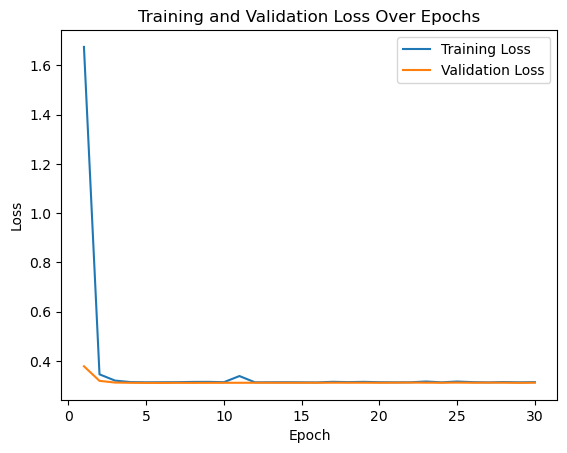

In [51]:
learning_rate = 0.001
num_epochs = 30

# Model, loss function, and optimizer
model = ImprovedSimpleNN()

criterion = MaskedCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []  # List to store validation losses

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # Initialize epoch training loss
    for inputs, labels, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels, masks)
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate the training loss
        
    epoch_train_loss /= len(train_loader.dataset)  # Calculate average training loss for the epoch
    train_losses.append(epoch_train_loss)  # Store the training loss value
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    epoch_valid_loss = 0.0  # Initialize epoch validation loss
    with torch.no_grad():
        for inputs, labels, masks in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels, masks)
            epoch_valid_loss += loss.item() * inputs.size(0)  # Accumulate the validation loss
            
    epoch_valid_loss /= len(valid_loader.dataset)  # Calculate average validation loss for the epoch
    valid_losses.append(epoch_valid_loss)  # Store the validation loss value
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}')

# Plot both training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     37860
           1       0.29      0.00      0.01      3900

    accuracy                           0.91     41760
   macro avg       0.60      0.50      0.48     41760
weighted avg       0.85      0.91      0.86     41760

Confusion Matrix:


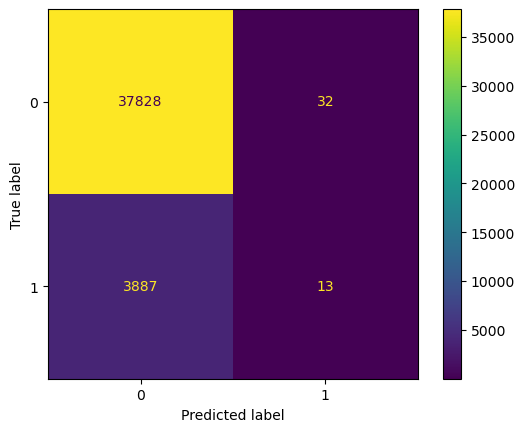

In [53]:
# # Testing the model
# model.eval()  # Set the model to evaluation mode
# y_pred = []
# with torch.no_grad():
#     for inputs, _ in valid_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         y_pred.extend(predicted.tolist())

# # y_pred = np.array(y_pred)

# show_basic_metrics(valid_y, y_pred, valid_ids, False)

# Testing the model
model.eval()  # Set the model to evaluation mode
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels, masks in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and ground truth where the mask is valid
        y_pred.extend(predicted[masks].tolist())
        y_true.extend(labels[masks].tolist())

# Convert to numpy arrays for metric calculation
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Assuming you have a function show_basic_metrics to display metrics
show_basic_metrics(y_true, y_pred, valid_ids, False)
